In [864]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Lecture 02

## Implementation of Perceptron


## 1. Import Statements

In [865]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Changes-----------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# Changes-----------------------------------
 
%matplotlib inline

## 2. Setup Global Parameters

In [866]:
###----------------
### Some parameters
###----------------

# Directory locations
inpDir = '../../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 5001  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## 3. Generate Data Set

Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.


In [867]:
X, y = datasets.make_moons(n_samples=N_SAMPLES, 
                           shuffle=True, 
                           noise=NOISE, 
                           random_state=RANDOM_STATE)
X.shape, y.shape

((1000, 2), (1000,))

## 4. Visualization

DataFrames are easier to visualize


In [868]:
data_df = pd.DataFrame(X, columns=['A', 'B'])
data_df['target'] = y
data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


<div style="font-family: Arial; font-size:1.2em;">
    We will keep 10%, i.e. 100 records for testing and remaining records will be used in training. Note that the data is already random.
</div>

In [869]:
x_train = X[:900]
x_test = X[900:]
y_train = y[:900]
y_test = y[900:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((900, 2), (100, 2), (900,), (100,))

# Over to Perceptron

<div style="font-family: Arial; font-size:1.1em;">

Our output is binary. To keep the code in line with what we discussed in the lecture, we will simply output 1 for positive values of 'z' and zero for negative values.
</div>

<img src="../../images/dnn_nb_s03_fig1.png" width='350' align = 'left'>


$$
\begin{aligned}
z & = 1.0 \circ w_0 + x_1 \circ w_1 + x_2 \circ w_2 \\
\mathrm{or}\\
z & = X\circ W \\
\end{aligned}
$$
<br/>


$$
\begin{equation*}
    \hat{y} = \begin{cases}
      1.0, & \text{for z>=0}\  \\
      0.0, & \text{for z<0}\
    \end{cases}
\end{equation*}
$$

In [870]:
torch.version.cuda

'12.1'

In [871]:
torch.cuda.current_device()

0

In [872]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce GTX 1650'

In [873]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [874]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)  # layer 1
        x = self.sigmoid(x)
        return x

In [875]:
model = Model(X.shape[1]).to(device)
print(model)

Model(
  (layer1): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [876]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.5124,  0.0555]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.4639], device='cuda:0', requires_grad=True)]

In [877]:
print(f" Number of parameters {len(list(model.parameters()))}")

 Number of parameters 2


In [878]:
print(f" Layer 1 Weights {(list(model.parameters())[0].shape)}")
print(f" Layer 1 Bias    {(list(model.parameters())[1].shape)}")


 Layer 1 Weights torch.Size([1, 2])
 Layer 1 Bias    torch.Size([1])


In [879]:
train_X = Variable(torch.Tensor(x_train)).to(device)
train_y = Variable(torch.Tensor(y_train)).to(device)
test_X = Variable(torch.Tensor(x_test)).to(device)
test_y = Variable(torch.Tensor(y_test)).to(device)
train_X.shape, train_y.shape, test_X.shape, test_y.shape

(torch.Size([900, 2]),
 torch.Size([900]),
 torch.Size([100, 2]),
 torch.Size([100]))

In [881]:
loss_fn = nn.BCEWithLogitsLoss()

trloss = []
tloss = []
n_epoch = []
acc = []
tacc = []

optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)  # optimizer


# Iteration

for epoch in range(EPOCHS):
    ### Training
    model.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model(train_X).squeeze() # squeeze to remove extra `1` dimensions, 
                                        #this won't work unless model and data are on same device
    y_pred = torch.round(y_logits)  
    
    # turn logits -> pred probs -> pred labls
    
    # 2. Calculate loss/accuracy
   
    loss = loss_fn(y_logits, train_y)  # Using nn.BCEWithLogitsLoss works with raw logit
    accuracy = accuracy_score(train_y.cpu(), y_pred.data.cpu())

    trloss.append(loss.data.item())
    acc.append(accuracy)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        
        test_logits = model(test_X).squeeze()
        test_pred = torch.round(test_logits)
        
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, test_y)
        test_acc = accuracy_score(test_y.cpu(), test_pred.data.cpu())

        tloss.append(test_loss.data.item())
        tacc.append(test_acc)
        n_epoch.append(epoch)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss.data.item():.5f}, Accuracy: {accuracy:.2f}% | Test loss: {test_loss.data.item():.5f}, Test acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 0.73501, Accuracy: 0.42% | Test loss: 0.75704, Test acc: 0.58%
Epoch: 10 | Loss: 0.64931, Accuracy: 0.52% | Test loss: 0.65591, Test acc: 0.67%
Epoch: 20 | Loss: 0.60496, Accuracy: 0.81% | Test loss: 0.61448, Test acc: 0.89%
Epoch: 30 | Loss: 0.59262, Accuracy: 0.83% | Test loss: 0.60113, Test acc: 0.89%
Epoch: 40 | Loss: 0.58508, Accuracy: 0.83% | Test loss: 0.59370, Test acc: 0.89%
Epoch: 50 | Loss: 0.58098, Accuracy: 0.84% | Test loss: 0.59005, Test acc: 0.88%
Epoch: 60 | Loss: 0.57799, Accuracy: 0.84% | Test loss: 0.58743, Test acc: 0.89%
Epoch: 70 | Loss: 0.57573, Accuracy: 0.85% | Test loss: 0.58559, Test acc: 0.90%
Epoch: 80 | Loss: 0.57400, Accuracy: 0.85% | Test loss: 0.58418, Test acc: 0.90%
Epoch: 90 | Loss: 0.57263, Accuracy: 0.85% | Test loss: 0.58303, Test acc: 0.90%
Epoch: 100 | Loss: 0.57154, Accuracy: 0.85% | Test loss: 0.58210, Test acc: 0.90%
Epoch: 110 | Loss: 0.57065, Accuracy: 0.86% | Test loss: 0.58134, Test acc: 0.90%
Epoch: 120 | Loss: 0.56991,

Epoch: 300 | Loss: 0.56478, Accuracy: 0.86% | Test loss: 0.57636, Test acc: 0.91%
Epoch: 310 | Loss: 0.56466, Accuracy: 0.86% | Test loss: 0.57628, Test acc: 0.91%
Epoch: 320 | Loss: 0.56455, Accuracy: 0.86% | Test loss: 0.57620, Test acc: 0.91%
Epoch: 330 | Loss: 0.56445, Accuracy: 0.86% | Test loss: 0.57613, Test acc: 0.91%
Epoch: 340 | Loss: 0.56435, Accuracy: 0.86% | Test loss: 0.57607, Test acc: 0.91%
Epoch: 350 | Loss: 0.56426, Accuracy: 0.86% | Test loss: 0.57600, Test acc: 0.91%
Epoch: 360 | Loss: 0.56417, Accuracy: 0.86% | Test loss: 0.57595, Test acc: 0.91%
Epoch: 370 | Loss: 0.56409, Accuracy: 0.86% | Test loss: 0.57589, Test acc: 0.91%
Epoch: 380 | Loss: 0.56401, Accuracy: 0.86% | Test loss: 0.57585, Test acc: 0.91%
Epoch: 390 | Loss: 0.56394, Accuracy: 0.86% | Test loss: 0.57580, Test acc: 0.91%
Epoch: 400 | Loss: 0.56387, Accuracy: 0.86% | Test loss: 0.57576, Test acc: 0.90%
Epoch: 410 | Loss: 0.56380, Accuracy: 0.86% | Test loss: 0.57572, Test acc: 0.90%
Epoch: 420 | Los

In [882]:
list(model.parameters())

[Parameter containing:
 tensor([[  8.1936, -36.3593]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.7873], device='cuda:0', requires_grad=True)]

In [883]:
loss_df = pd.DataFrame(
    {"epoch": n_epoch, "loss": trloss, "test loss": tloss, "acc": acc, "test acc": tacc}
)
loss_df.head()

,epoch,loss,test loss,acc,test acc
0,0,0.735006,0.757036,0.418889,0.58
1,1,0.723361,0.741939,0.488889,0.58
2,2,0.712288,0.727988,0.491111,0.58
3,3,0.701963,0.715335,0.491111,0.58
4,4,0.692483,0.704017,0.491111,0.58


<Axes: xlabel='epoch'>

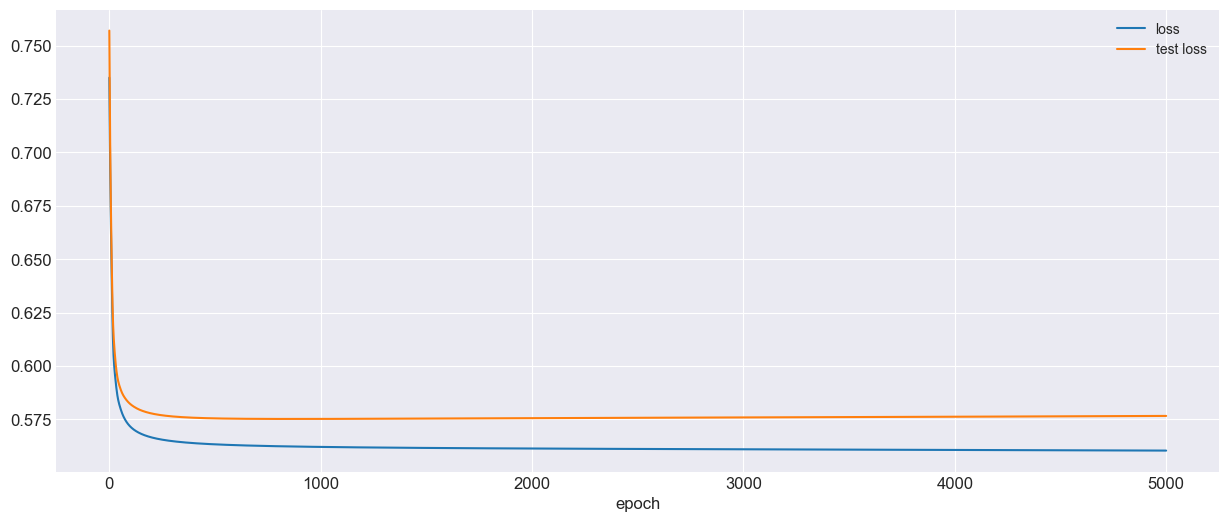

In [884]:
loss_df.plot(x="epoch", y=["loss", "test loss"])

<Axes: xlabel='epoch'>

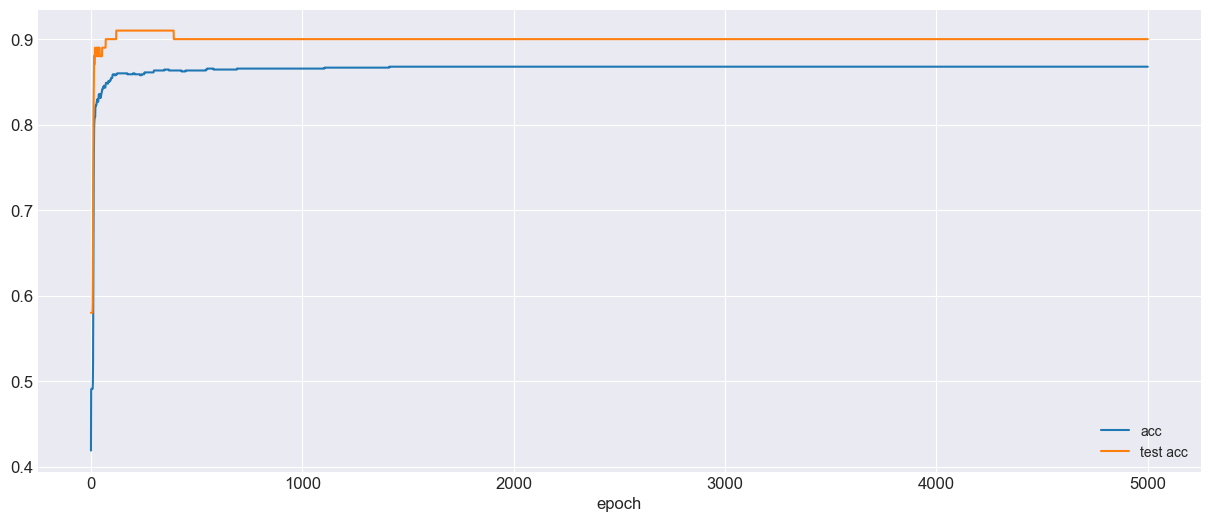

In [885]:
loss_df.plot(x="epoch", y=["acc", "test acc"])

## 7. Predictions

### Train Set

In [886]:
test_logits = model(test_X).squeeze()
test_pred = torch.round(test_logits)

# 2. Caculate loss/accuracy
test_loss = loss_fn(test_logits, test_y)
test_acc = accuracy_score(test_y.cpu(), test_pred.data.cpu())


print(f"Accuracy score on Test Data : {test_acc: .4f}")

Accuracy score on Test Data :  0.9000


In [887]:
cm = confusion_matrix(test_y.cpu(), test_pred.data.cpu())
cm

array([[55,  3],
       [ 7, 35]], dtype=int64)

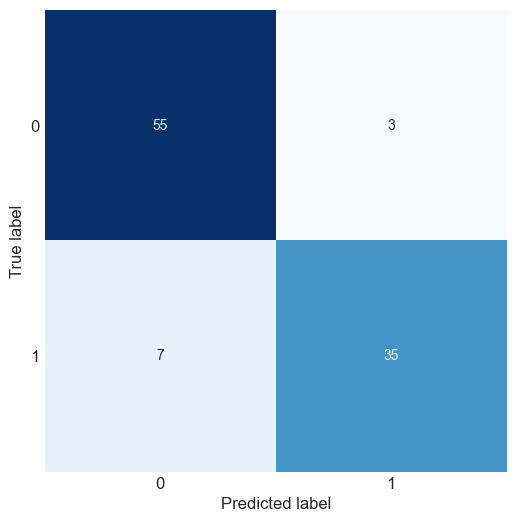

In [889]:
fig, ax = plt.subplots(figsize=(6, 6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

disp.plot(ax=ax, cmap="Blues", colorbar=False)

plt.grid()